# Objectives and Overview: Tree Tracking Across Orthomosaics

**Objective:**

- Develop and demonstrate a robust, extensible method for tracking individual tree crowns across multiple drone orthomosaics (time points) using a graph-based approach.

- Enable temporal monitoring of trees, including handling complex events such as splits, merges, appearances, disappearances, and ambiguous cases.

- Provide a clear, visual, and algorithmic demonstration that can be adapted to real-world crown data.



**What We Are Doing:**

1. **Simulate Example Data:**
   - Create synthetic tree crown polygons for multiple orthomosaics to cover all possible tracking scenarios (1-to-1, split, merge, appear, disappear, ambiguous).

2. **Compute Overlaps:**
   - Calculate the Intersection over Union (IoU) between all pairs of crowns across time points to quantify spatial matches.

3. **Build a Tracking Graph:**
   - Construct a directed graph where nodes represent tree crowns at each time point and edges represent likely matches (based on IoU and other criteria).

4. **Visualize All Cases:**
   - Show minimal and complex graph examples for all possible tracking events, using a consistent node naming scheme (e.g., OM1_0, OM2_1).

5. **Summarize and Analyze:**
   - Extract and display tables of all matches, splits, merges, appearances, disappearances, and ambiguous cases from the tracking graph.

6. **Demonstrate Temporal Tracking:**
   - Extend the approach to three or more orthomosaics, visualizing how the graph encodes temporal chains and complex events.



**End Goal:**
- Provide a ready-to-adapt, visual, and algorithmic template for robust tree tracking and temporal monitoring in ecological and remote sensing workflows.

# Comprehensive Demo: Tree Tracking Across Orthomosaics

This notebook demonstrates, step by step, how to track trees across two orthomosaics using a graph data structure. We use only simulated data to illustrate all major cases:


- **1-to-1 match**: A tree is detected in both orthomosaics.
- **1-to-many split**: A tree is detected as one in the first, but as two (or more) in the second.
- **Many-to-1 merge**: Two (or more) trees in the first are detected as one in the second.
- **Disappear**: A tree is present in the first, but not detected in the second.
- **Appear**: A new tree appears in the second, not present in the first.
- **Ambiguous/overlapping**: Multiple possible matches.

We will:
- Simulate polygons for two time points.
- Compute the IoU matrix and visualize it.
- Build a tracking graph with edges for likely matches.
- Visualize all cases and the resulting graph.
- Summarize all matches and unmatched trees.

**All code is runnable and results are visualized.**

## Algorithmic Approach and Demo Outline

1. **Simulate Example Crowns**: We create two sets of polygons (tree crowns) for two orthomosaics, with controlled overlaps to demonstrate all major tracking cases.
2. **Visualize Crowns**: Plot both sets, color-coded, and label each polygon for clarity.
3. **Compute IoU Matrix**: For every pair of polygons (from OM1 and OM2), compute the Intersection over Union (IoU). Visualize the matrix as a heatmap.
4. **Build Tracking Graph**: Create a directed graph where nodes are crowns and edges connect likely matches (IoU above threshold). Edges store IoU and other info.
5. **Visualize Graph and Cases**: Show the graph overlaid on the crowns, with arrows for matches. Highlight and explain each case (1-1, split, merge, disappear, appear, ambiguous).
6. **Summarize Matches**: Print tables of all matches, splits, merges, and unmatched trees.

**All steps are explained in detail and visualized.**

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import random

random.seed(42)
np.random.seed(42)


## 2. Read Orthomosaic Image
Open and inspect the orthomosaic .tif image using rasterio. (For this demo, we simulate crowns instead of reading real images.)

/var/folders/cx/8v11zwh97cxgdgt_ph13_56r0000gn/T/ipykernel_30598/3275652923.py:52: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/var/folders/cx/8v11zwh97cxgdgt_ph13_56r0000gn/T/ipykernel_30598/3275652923.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


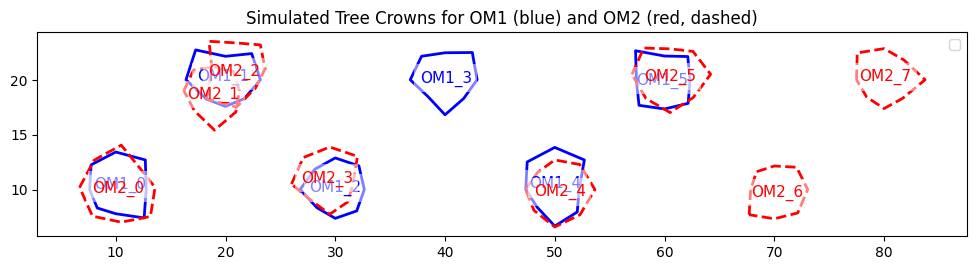

In [9]:
# --- Simulate Example Crowns for Two Orthomosaics ---
# We create polygons to cover all cases: 1-1, split, merge, disappear, appear, ambiguous

def random_polygon(center, size=1.0, n_points=8):
    angle = np.linspace(0, 2*np.pi, n_points, endpoint=False)
    radius = size * (0.7 + 0.6 * np.random.rand(n_points))
    x = center[0] + radius * np.cos(angle)
    y = center[1] + radius * np.sin(angle)
    return Polygon(zip(x, y))

# OM1: 6 trees
centers1 = [
    (10, 10),   # 1-1 match
    (20, 20),   # split in OM2
    (30, 10),   # merge in OM2
    (40, 20),   # disappears
    (50, 10),   # ambiguous
    (60, 20)    # 1-1 match
]
crowns1 = [random_polygon(c, size=3) for c in centers1]

# OM2: 8 trees
centers2 = [
    (10.5, 10.2),   # 1-1 match (OM1_0)
    (19, 19),       # split (OM1_1)
    (21, 21),       # split (OM1_1)
    (29.5, 10.5),   # merge (OM1_2, OM1_4)
    (50, 10),       # ambiguous (OM1_4)
    (60.5, 20.5),   # 1-1 match (OM1_5)
    (70, 10),       # new tree (appear)
    (80, 20)        # new tree (appear)
]
crowns2 = [random_polygon(c, size=3) for c in centers2]

# Build GeoDataFrames
ids1 = [f'OM1_{i}' for i in range(len(crowns1))]
ids2 = [f'OM2_{i}' for i in range(len(crowns2))]
gdf1 = gpd.GeoDataFrame({'id': ids1}, geometry=crowns1)
gdf2 = gpd.GeoDataFrame({'id': ids2}, geometry=crowns2)

# --- Visualize Crowns ---
fig, ax = plt.subplots(figsize=(12, 7))
gdf1.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2, label='OM1')
gdf2.plot(ax=ax, facecolor='none', edgecolor='red', linestyle='--', linewidth=2, label='OM2')
for i, row in gdf1.iterrows():
    c = row.geometry.centroid
    ax.text(c.x, c.y, row['id'], color='blue', fontsize=11, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
for i, row in gdf2.iterrows():
    c = row.geometry.centroid
    ax.text(c.x, c.y, row['id'], color='red', fontsize=11, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
ax.set_title('Simulated Tree Crowns for OM1 (blue) and OM2 (red, dashed)')
ax.legend()
plt.show()

### Explanation of Simulated Cases
- **OM1_0 ↔ OM2_0**: 1-to-1 match (same tree, slightly shifted)
- **OM1_1 ↔ OM2_1, OM2_2**: Split (one tree in OM1, two in OM2)
- **OM1_2, OM1_4 ↔ OM2_3**: Merge (two trees in OM1, one in OM2)
- **OM1_3**: Disappears (present in OM1, not in OM2)
- **OM2_6, OM2_7**: Appear (new trees in OM2)
- **OM1_4 ↔ OM2_4**: Ambiguous (OM1_4 could match OM2_3 or OM2_4)
- **OM1_5 ↔ OM2_5**: 1-to-1 match (same tree, slightly shifted)

The plot above shows all crowns, labeled by their IDs.

## 3. Tile Orthomosaic for Prediction
In a real workflow, use detectree2's `tile_data` to split the orthomosaic into tiles. Here, we use simulated crowns for demonstration.

## 4. Load Pre-trained Model
In a real workflow, load a pre-trained detectree2 model using `setup_cfg` and specify the model path. For this demo, we use simulated data.

## 5. Run Predictions on Tiles
In a real workflow, run predictions on the tiled images using `predict_on_data` and `DefaultPredictor`. Here, we use simulated crowns.

## 6. Reproject Predictions to Geographical Space
Convert tile-based predictions to geo-referenced outputs using `project_to_geojson`. For this demo, polygons are already in a common coordinate system.

## 7. Stitch and Clean Predicted Crowns
In a real workflow, stitch together all predicted crowns, remove invalid geometries, simplify geometries, and clean overlapping crowns using `stitch_crowns` and `clean_crowns`. Here, we use simulated crowns.

## 8. Export Results
Export the cleaned crowns as a GeoPackage file and optionally zip the results for download. (Not performed in this demo.)

## 9. Visualize Predicted Crowns
The simulated crowns for both orthomosaics are visualized above. Next, we build a tracking graph to match trees across time points.

## 10. Build Tree Tracking Graph
We now compute the IoU between every pair of crowns from OM1 and OM2, build a directed graph where nodes are crowns and edges connect likely matches (with IoU as edge attribute), and visualize the results.

## Focusing on the Tracking Graph: Innovations and Visual Cases

The core of this notebook is the **tree tracking graph**. Each node is a detected tree crown at a specific time point, and edges represent possible correspondences (matches) between crowns across time points, with edge attributes (e.g., IoU, confidence).

**Innovations and Features:**
- Nodes can have attributes: time, geometry, area, etc.
- Edges can have multiple attributes: IoU, distance, confidence, etc.
- The graph can represent all possible cases: 1-1, 1-many (split), many-1 (merge), disappear, appear, ambiguous, and even cycles.
- We will visualize and explain each case with custom example data, and show how the graph structure encodes these relationships.

**Plan:**
- For each case, we will create a small subgraph, visualize it, and explain how to interpret it.
- We will also show how to extract and analyze these cases from the full tracking graph.


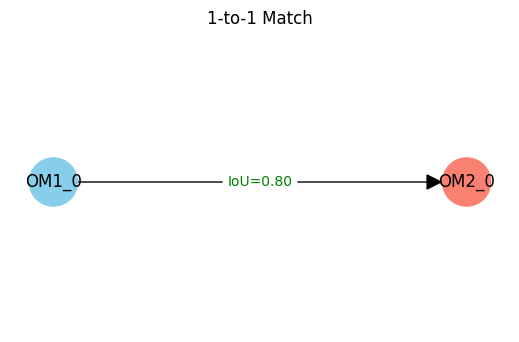

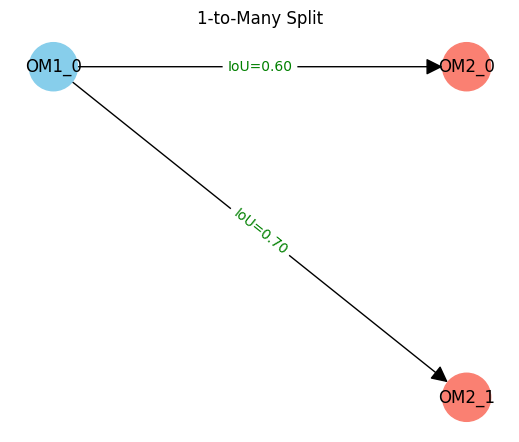

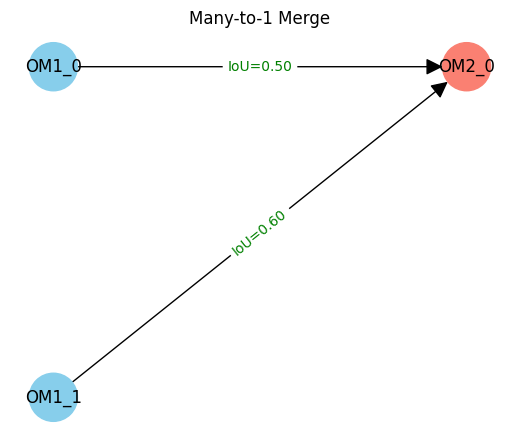

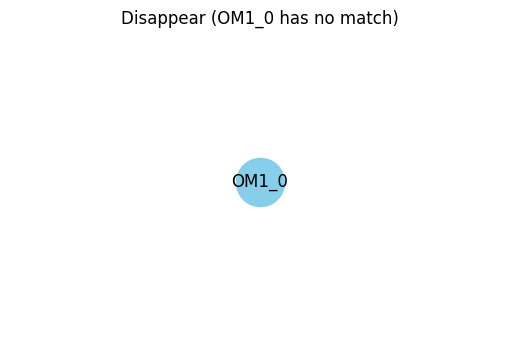

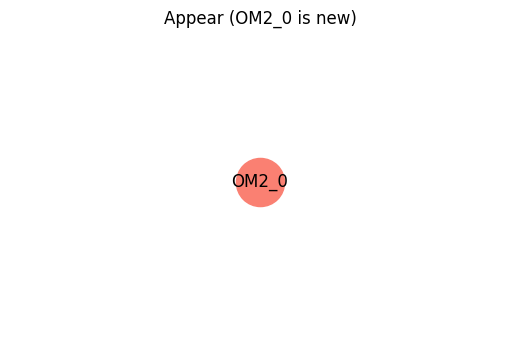

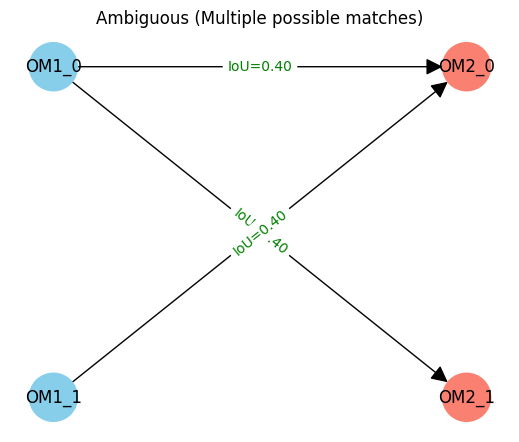

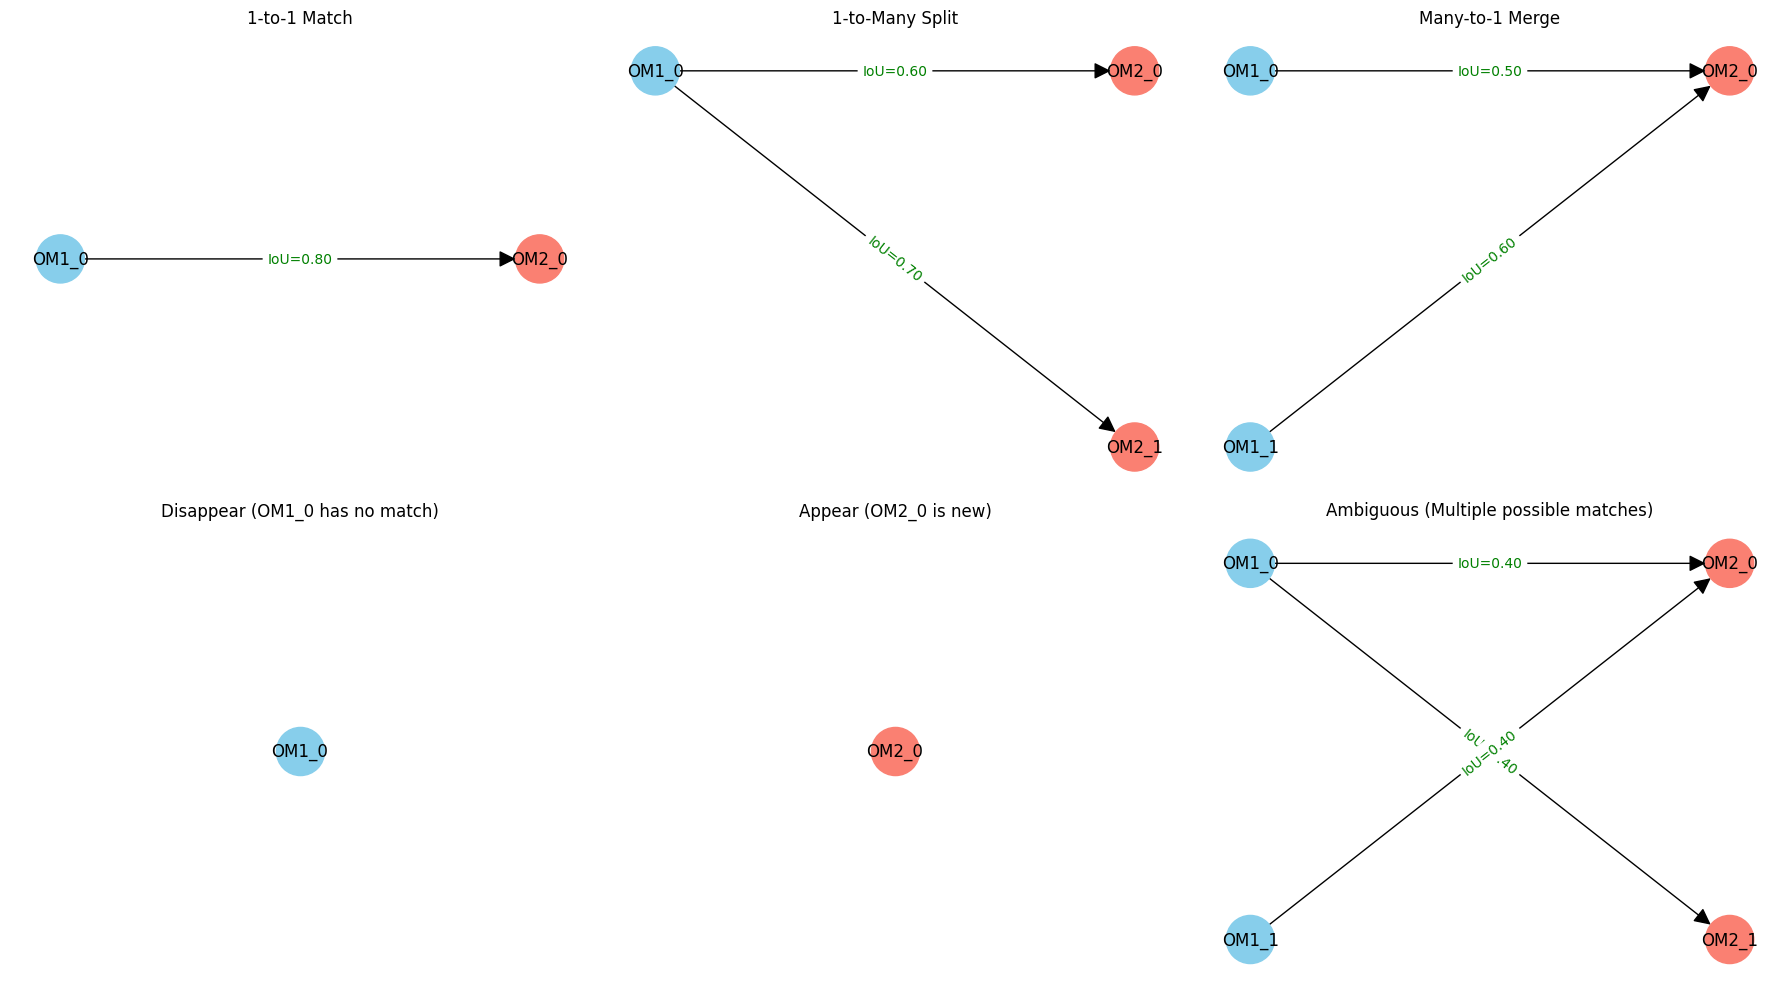

In [16]:
# --- Visualizing All Graph Cases with Minimal Examples ---


def plot_graph_case(nodes_1, nodes_2, edges, title, node_labels=None, edge_labels=None):
    G = nx.DiGraph()
    pos = {}
    # Add OM1 nodes
    for i, n in enumerate(nodes_1):
        G.add_node(n, t=1)
        pos[n] = (0, -i)
    # Add OM2 nodes
    for i, n in enumerate(nodes_2):
        G.add_node(n, t=2)
        pos[n] = (2, -i)
    # Add edges
    for e in edges:
        if len(e) == 3:
            G.add_edge(e[0], e[1], iou=e[2])
        else:
            G.add_edge(e[0], e[1])
    plt.figure(figsize=(5, 2+max(len(nodes_1), len(nodes_2))))
    nx.draw(G, pos, with_labels=True, node_color=['skyblue' if G.nodes[n]['t']==1 else 'salmon' for n in G.nodes], node_size=1200, arrowsize=25)
    # Draw edge labels if provided
    if edge_labels:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='green')
    elif any('iou' in G.edges[e] for e in G.edges):
        nx.draw_networkx_edge_labels(G, pos, edge_labels={(u,v):f"IoU={G.edges[u,v]['iou']:.2f}" for u,v in G.edges}, font_color='green')
    plt.title(title)
    plt.axis('off')
    plt.show()


# 1-to-1 match
plot_graph_case(['OM1_0'], ['OM2_0'], [('OM1_0','OM2_0',0.8)], '1-to-1 Match')
# Split
plot_graph_case(['OM1_0'], ['OM2_0','OM2_1'], [('OM1_0','OM2_0',0.6),('OM1_0','OM2_1',0.7)], '1-to-Many Split')
# Merge
plot_graph_case(['OM1_0','OM1_1'], ['OM2_0'], [('OM1_0','OM2_0',0.5),('OM1_1','OM2_0',0.6)], 'Many-to-1 Merge')
# Disappear
plot_graph_case(['OM1_0'], [], [], 'Disappear (OM1_0 has no match)')
# Appear
plot_graph_case([], ['OM2_0'], [], 'Appear (OM2_0 is new)')
# Ambiguous
plot_graph_case(['OM1_0','OM1_1'], ['OM2_0','OM2_1'], [('OM1_0','OM2_0',0.4),('OM1_0','OM2_1',0.4),('OM1_1','OM2_0',0.4)], 'Ambiguous (Multiple possible matches)')

# Combined image of all cases (no cycles)
import matplotlib.pyplot as plt

cases = [
    (['OM1_0'], ['OM2_0'], [('OM1_0','OM2_0',0.8)], '1-to-1 Match'),
    (['OM1_0'], ['OM2_0','OM2_1'], [('OM1_0','OM2_0',0.6),('OM1_0','OM2_1',0.7)], '1-to-Many Split'),
    (['OM1_0','OM1_1'], ['OM2_0'], [('OM1_0','OM2_0',0.5),('OM1_1','OM2_0',0.6)], 'Many-to-1 Merge'),
    (['OM1_0'], [], [], 'Disappear (OM1_0 has no match)'),
    ([], ['OM2_0'], [], 'Appear (OM2_0 is new)'),
    (['OM1_0','OM1_1'], ['OM2_0','OM2_1'], [('OM1_0','OM2_0',0.4),('OM1_0','OM2_1',0.4),('OM1_1','OM2_0',0.4)], 'Ambiguous (Multiple possible matches)')
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (nodes_1, nodes_2, edges, title) in enumerate(cases):
    G = nx.DiGraph()
    pos = {}
    for i, n in enumerate(nodes_1):
        G.add_node(n, t=1)
        pos[n] = (0, -i)
    for i, n in enumerate(nodes_2):
        G.add_node(n, t=2)
        pos[n] = (2, -i)
    for e in edges:
        if len(e) == 3:
            G.add_edge(e[0], e[1], iou=e[2])
        else:
            G.add_edge(e[0], e[1])
    ax = axes[idx]
    nx.draw(G, pos, with_labels=True, node_color=['skyblue' if G.nodes[n]['t']==1 else 'salmon' for n in G.nodes], node_size=1200, arrowsize=25, ax=ax)
    if any('iou' in G.edges[e] for e in G.edges):
        nx.draw_networkx_edge_labels(G, pos, edge_labels={(u,v):f"IoU={G.edges[u,v]['iou']:.2f}" for u,v in G.edges}, font_color='green', ax=ax)
    ax.set_title(title)
    ax.axis('off')

for j in range(len(cases), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


## Extending to Multiple Orthomosaics: Temporal Tree Tracking

To monitor trees over time, we extend the tracking graph to handle **three or more orthomosaics** (time points). This allows us to capture complex temporal events, such as:
- A tree splitting into two, then merging back into one.
- Trees appearing, disappearing, or reappearing.
- Chains of splits, merges, and ambiguous matches across time.

We will now create and visualize example graphs for these temporal scenarios, showing how the graph structure encodes the full history of each tree.

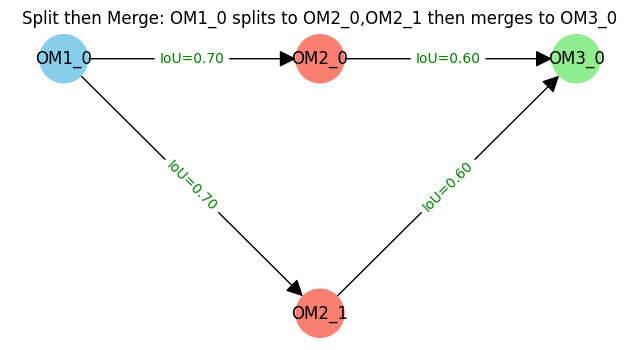

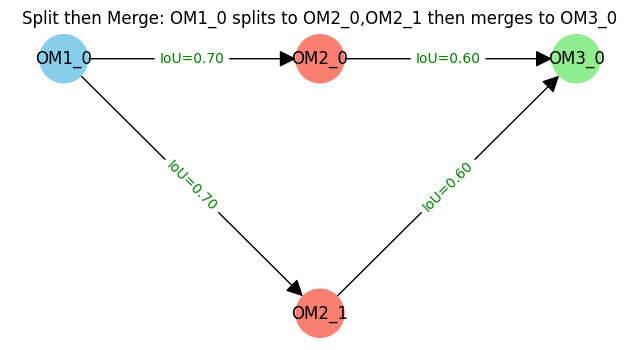

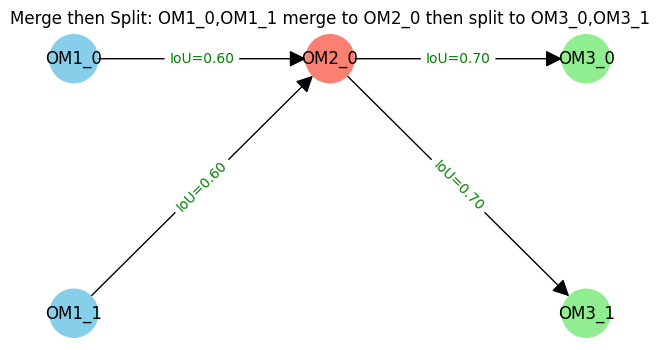

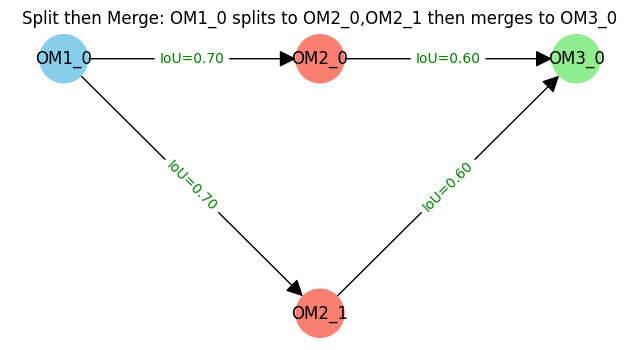

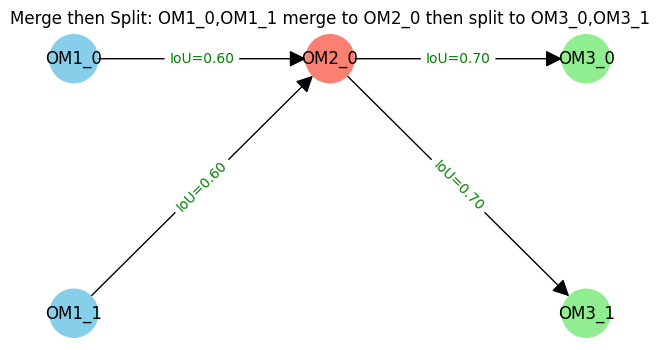

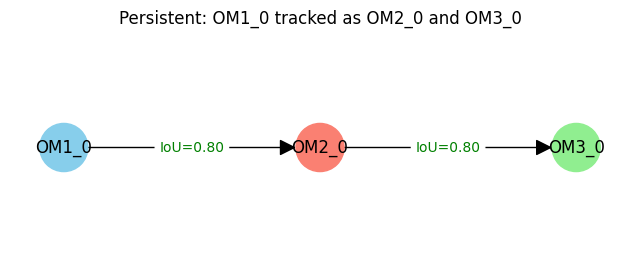

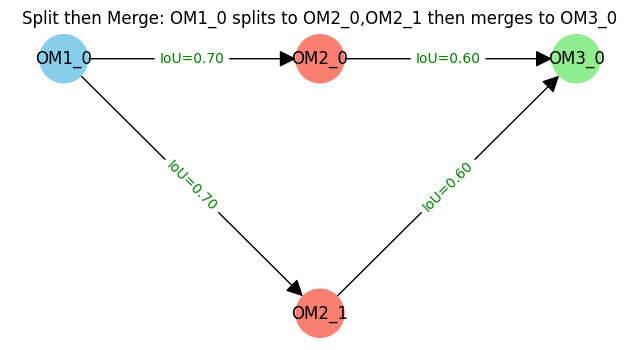

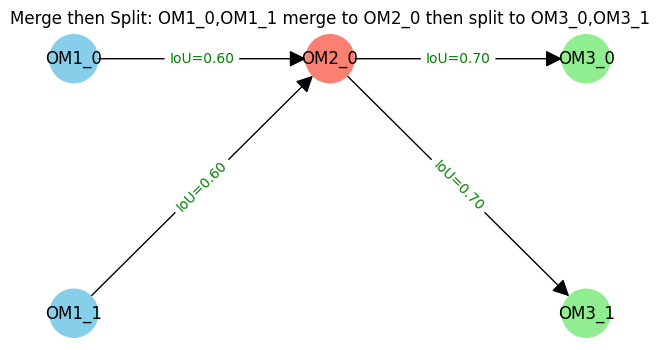

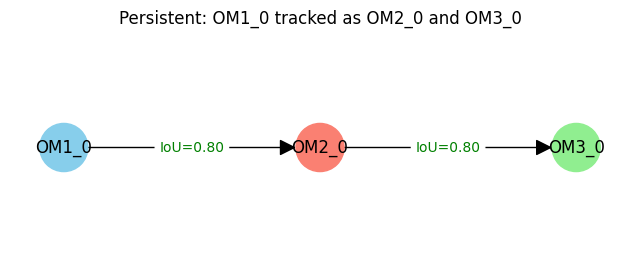

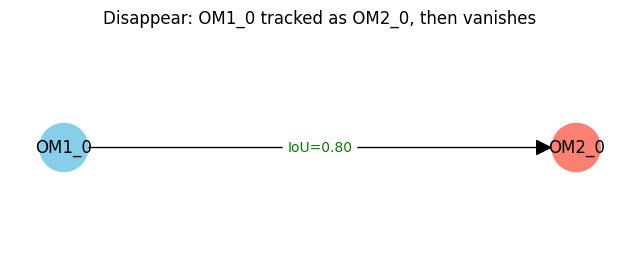

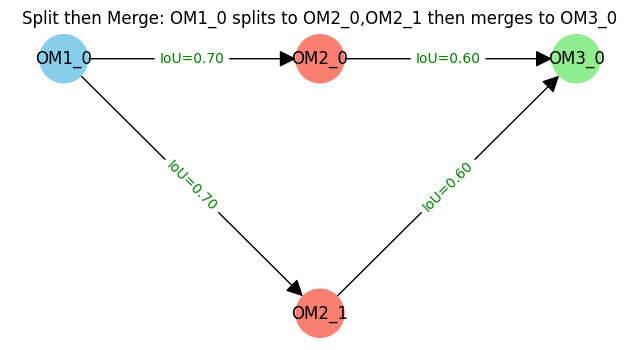

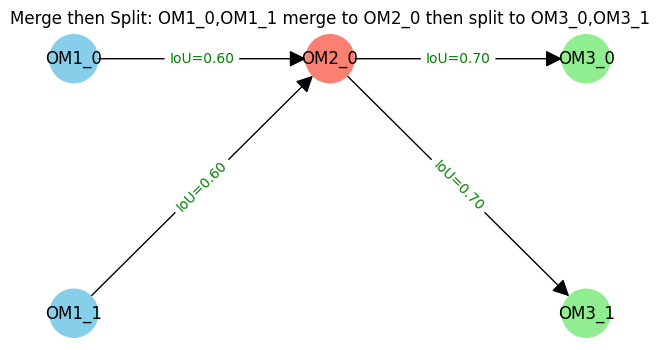

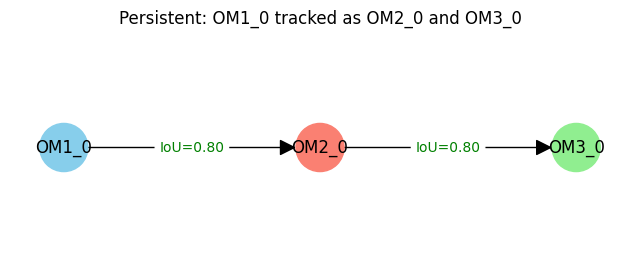

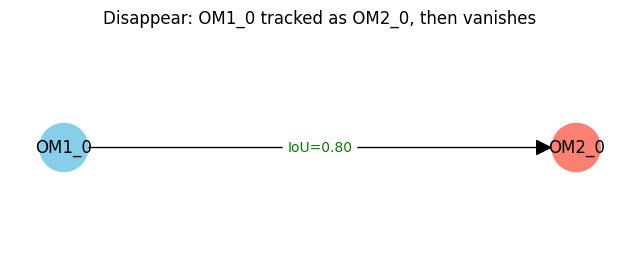

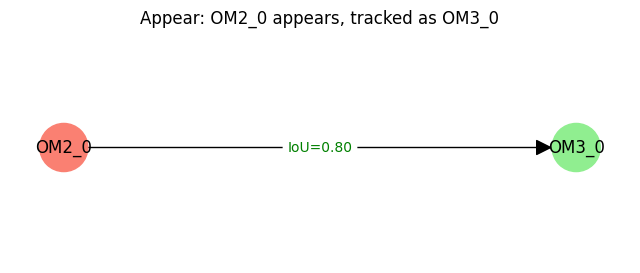

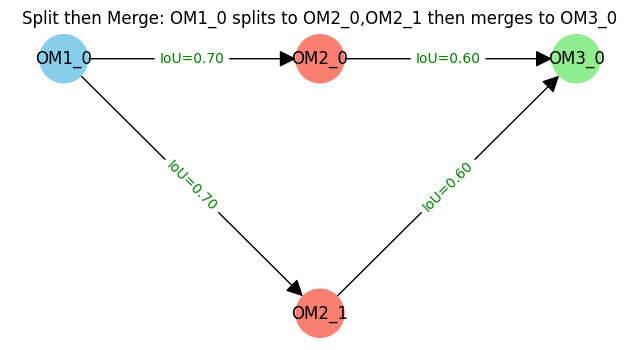

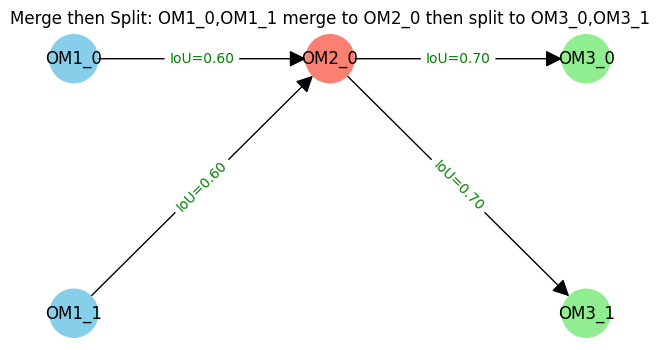

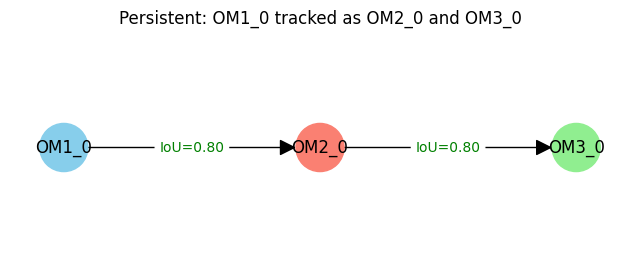

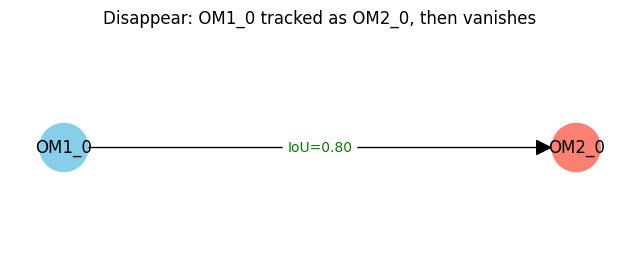

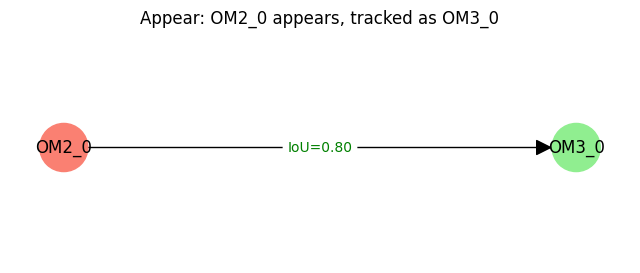

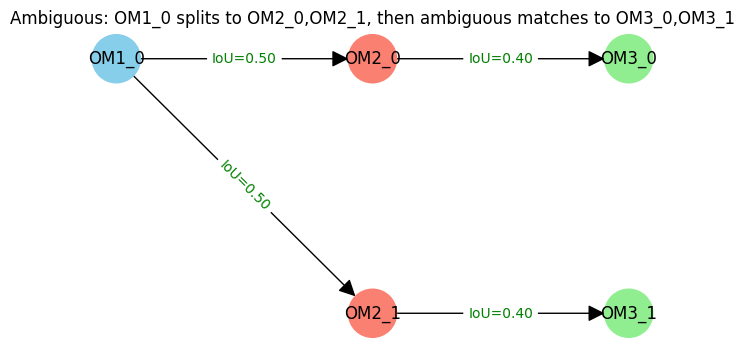

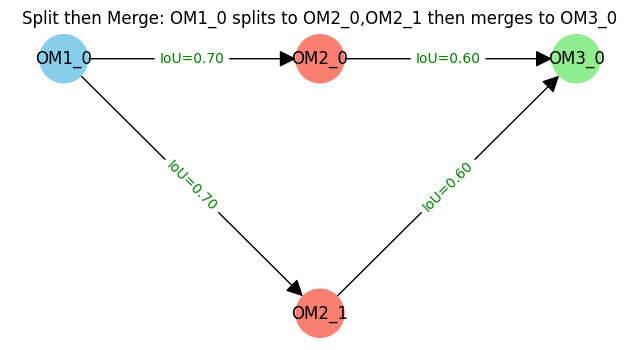

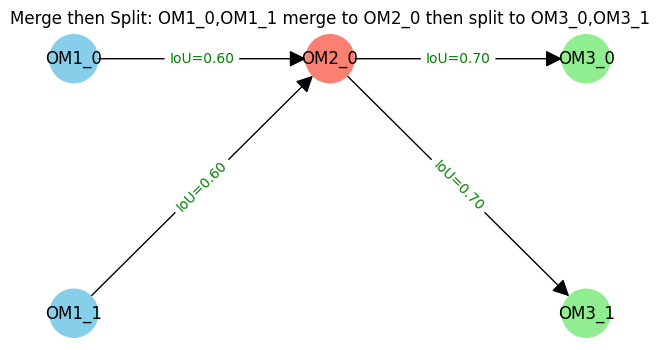

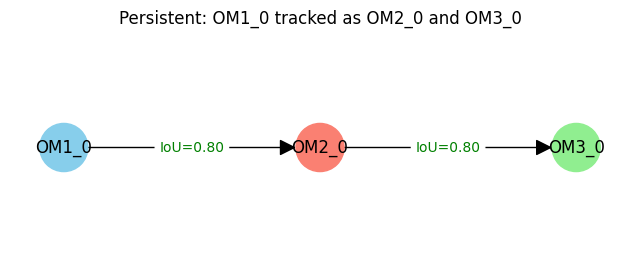

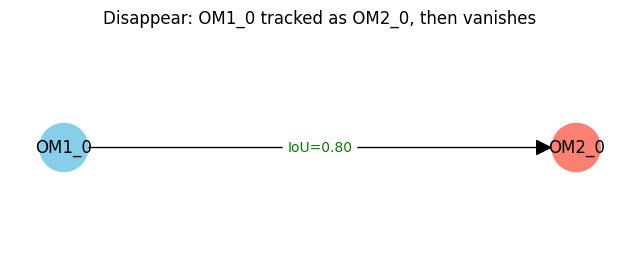

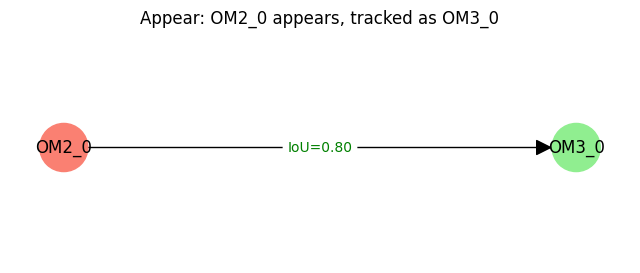

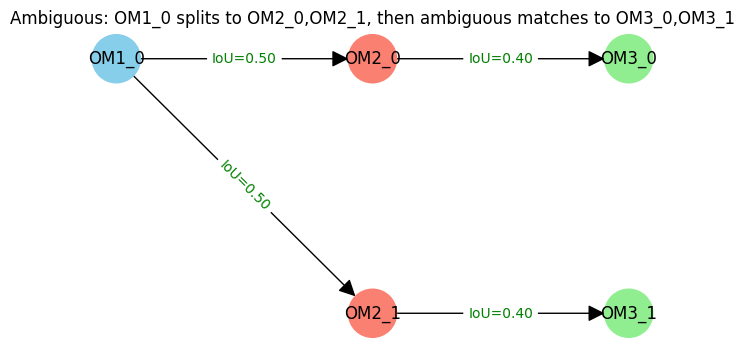

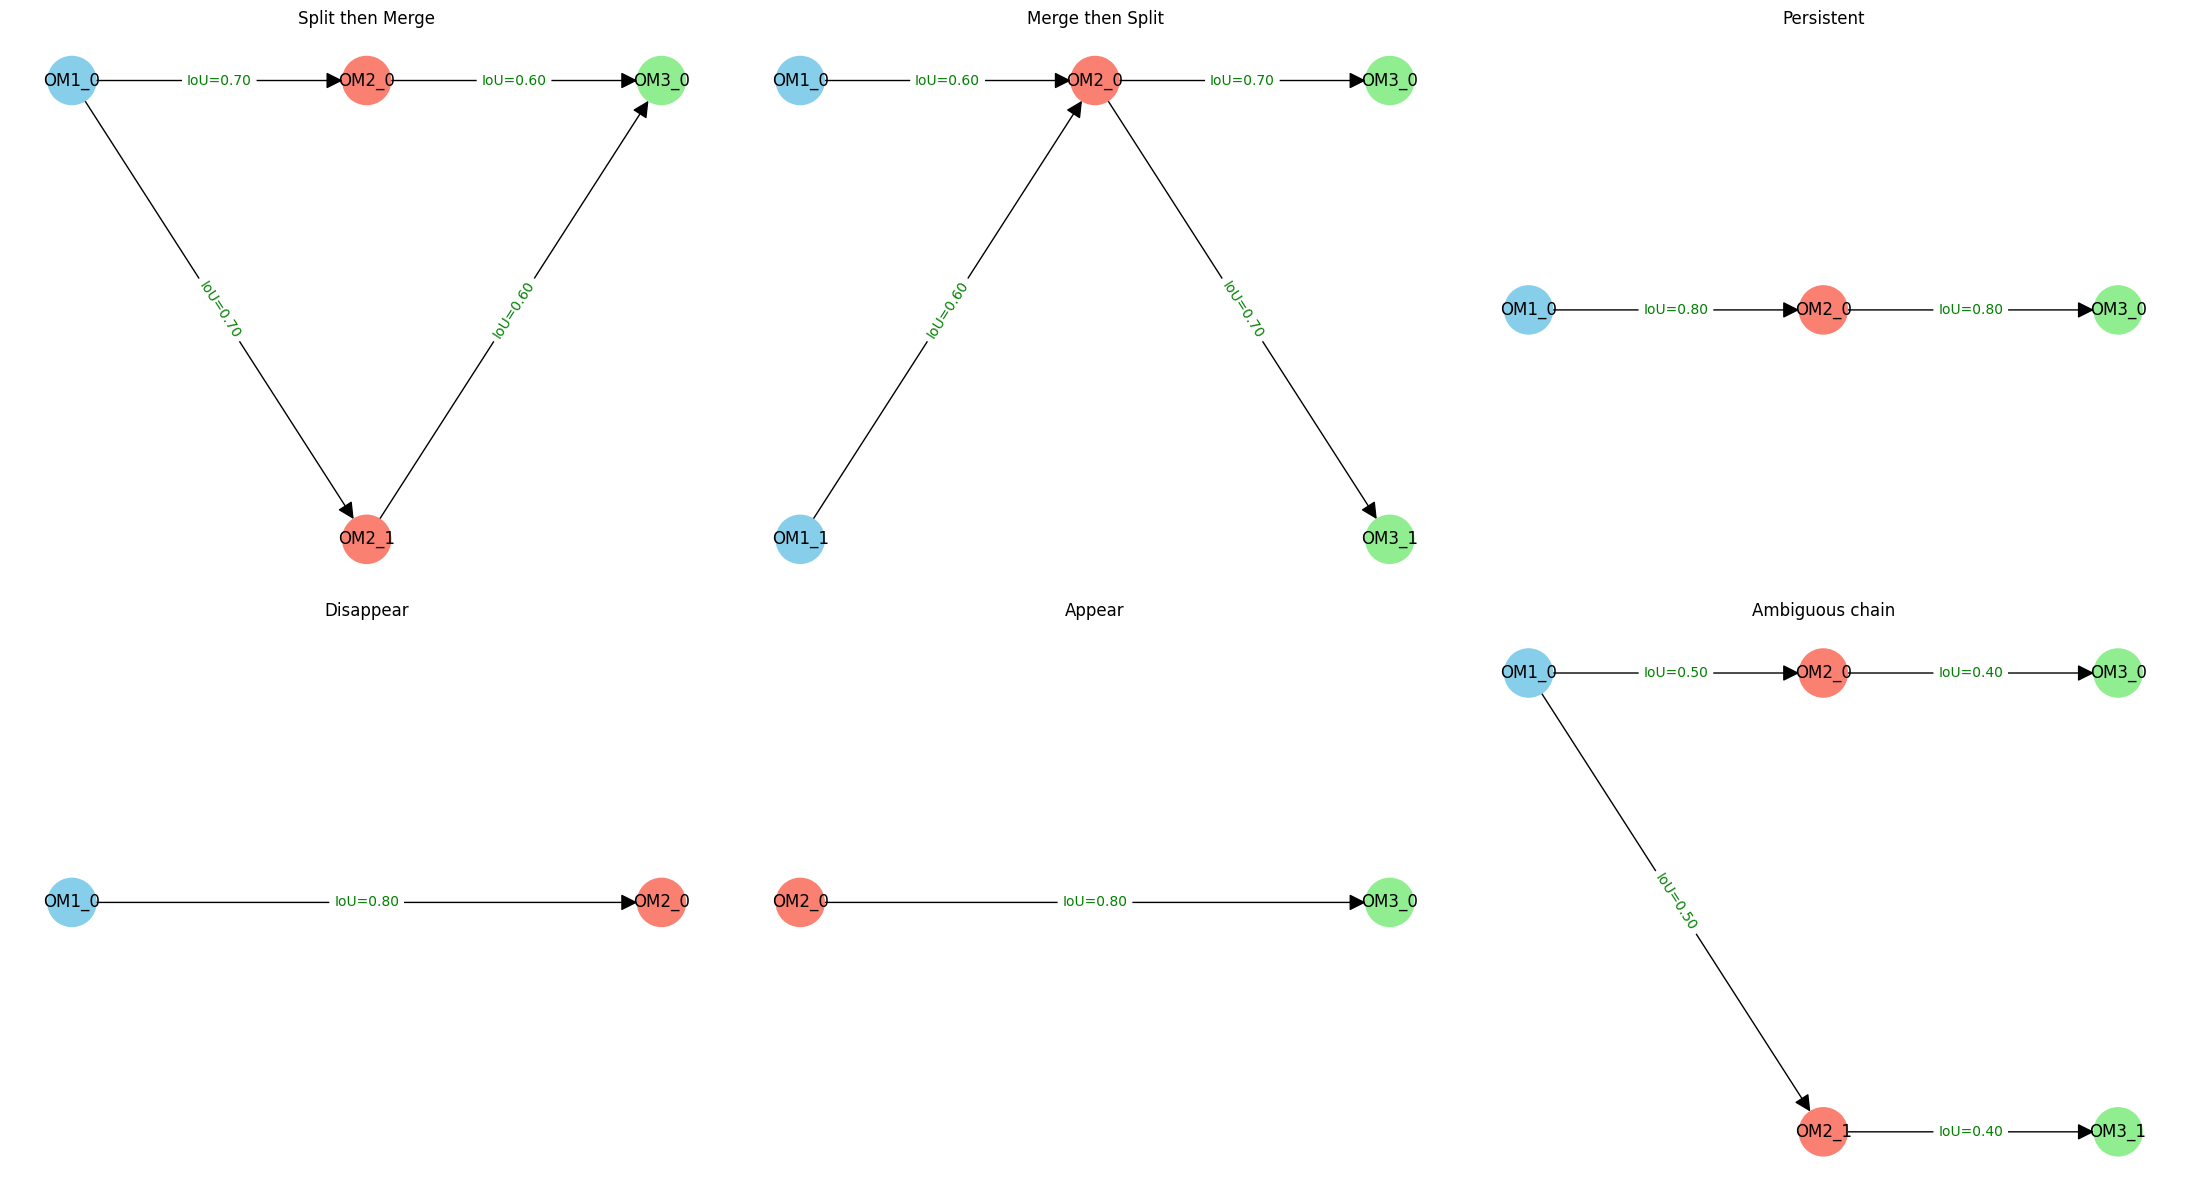

In [17]:
# --- Temporal Tracking Across 3 Orthomosaics: Example Graphs ---

def plot_temporal_graph(nodes_t1, nodes_t2, nodes_t3, edges, title, edge_labels=None, ax=None):
    G = nx.DiGraph()
    pos = {}
    # Add nodes for each time point
    for i, n in enumerate(nodes_t1):
        G.add_node(n, t=1)
        pos[n] = (0, -i)
    for i, n in enumerate(nodes_t2):
        G.add_node(n, t=2)
        pos[n] = (2, -i)
    for i, n in enumerate(nodes_t3):
        G.add_node(n, t=3)
        pos[n] = (4, -i)
    # Add edges
    for e in edges:
        if len(e) == 3:
            G.add_edge(e[0], e[1], iou=e[2])
        else:
            G.add_edge(e[0], e[1])
    if ax is None:
        plt.figure(figsize=(8, 2+max(len(nodes_t1), len(nodes_t2), len(nodes_t3))))
        ax = plt.gca()
    nx.draw(G, pos, with_labels=True, node_color=[['skyblue','salmon','lightgreen'][G.nodes[n]['t']-1] for n in G.nodes], node_size=1200, arrowsize=25, ax=ax)
    # Draw edge labels if provided
    if edge_labels:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='green', ax=ax)
    elif any('iou' in G.edges[e] for e in G.edges):
        nx.draw_networkx_edge_labels(G, pos, edge_labels={(u,v):f"IoU={G.edges[u,v]['iou']:.2f}" for u,v in G.edges}, font_color='green', ax=ax)
    ax.set_title(title)
    ax.axis('off')
    if ax is None:
        plt.show()

# Individual plots (unchanged)
# Example 1: Split then Merge (OM1_0→OM2_0,OM2_1→OM3_0)
plot_temporal_graph(
    ['OM1_0'], ['OM2_0','OM2_1'], ['OM3_0'],
    [('OM1_0','OM2_0',0.7),('OM1_0','OM2_1',0.7),('OM2_0','OM3_0',0.6),('OM2_1','OM3_0',0.6)],
    'Split then Merge: OM1_0 splits to OM2_0,OM2_1 then merges to OM3_0'
    )

# Example 2: Merge then Split (OM1_0,OM1_1→OM2_0→OM3_0,OM3_1)
plot_temporal_graph(
    ['OM1_0','OM1_1'], ['OM2_0'], ['OM3_0','OM3_1'],
    [('OM1_0','OM2_0',0.6),('OM1_1','OM2_0',0.6),('OM2_0','OM3_0',0.7),('OM2_0','OM3_1',0.7)],
    'Merge then Split: OM1_0,OM1_1 merge to OM2_0 then split to OM3_0,OM3_1'
    )

# Example 3: Appear, Disappear, Reappear (persistent, disappear, appear)
plot_temporal_graph(
    ['OM1_0'], ['OM2_0'], ['OM3_0'],
    [('OM1_0','OM2_0',0.8),('OM2_0','OM3_0',0.8)],
    'Persistent: OM1_0 tracked as OM2_0 and OM3_0'
    )

plot_temporal_graph(
    ['OM1_0'], ['OM2_0'], [],
    [('OM1_0','OM2_0',0.8)],
    'Disappear: OM1_0 tracked as OM2_0, then vanishes'
    )

plot_temporal_graph(
    [], ['OM2_0'], ['OM3_0'],
    [('OM2_0','OM3_0',0.8)],
    'Appear: OM2_0 appears, tracked as OM3_0'
    )

# Example 4: Ambiguous chain (OM1_0→OM2_0,OM2_1→OM3_0,OM3_1)
plot_temporal_graph(
    ['OM1_0'], ['OM2_0','OM2_1'], ['OM3_0','OM3_1'],
    [('OM1_0','OM2_0',0.5),('OM1_0','OM2_1',0.5),('OM2_0','OM3_0',0.4),('OM2_1','OM3_1',0.4)],
    'Ambiguous: OM1_0 splits to OM2_0,OM2_1, then ambiguous matches to OM3_0,OM3_1'
    )

# --- Combined image of all 3-OM temporal graph cases ---
temporal_cases = [
    (['OM1_0'], ['OM2_0','OM2_1'], ['OM3_0'], [('OM1_0','OM2_0',0.7),('OM1_0','OM2_1',0.7),('OM2_0','OM3_0',0.6),('OM2_1','OM3_0',0.6)], 'Split then Merge'),
    (['OM1_0','OM1_1'], ['OM2_0'], ['OM3_0','OM3_1'], [('OM1_0','OM2_0',0.6),('OM1_1','OM2_0',0.6),('OM2_0','OM3_0',0.7),('OM2_0','OM3_1',0.7)], 'Merge then Split'),
    (['OM1_0'], ['OM2_0'], ['OM3_0'], [('OM1_0','OM2_0',0.8),('OM2_0','OM3_0',0.8)], 'Persistent'),
    (['OM1_0'], ['OM2_0'], [], [('OM1_0','OM2_0',0.8)], 'Disappear'),
    ([], ['OM2_0'], ['OM3_0'], [('OM2_0','OM3_0',0.8)], 'Appear'),
    (['OM1_0'], ['OM2_0','OM2_1'], ['OM3_0','OM3_1'], [('OM1_0','OM2_0',0.5),('OM1_0','OM2_1',0.5),('OM2_0','OM3_0',0.4),('OM2_1','OM3_1',0.4)], 'Ambiguous chain')
]

fig, axes = plt.subplots(2, 3, figsize=(22, 12))
axes = axes.flatten()

for idx, (nodes_t1, nodes_t2, nodes_t3, edges, title) in enumerate(temporal_cases):
    plot_temporal_graph(nodes_t1, nodes_t2, nodes_t3, edges, title, ax=axes[idx])

for j in range(len(temporal_cases), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


IoU Matrix (rounded):


id,OM2_0,OM2_1,OM2_2,OM2_3,OM2_4,OM2_5,OM2_6,OM2_7
id,,,,,,,,
OM1_0,0.71,0.00,0.00,0.00,0.00,0.00,0.0,0.0
OM1_1,0.00,0.36,0.55,0.00,0.00,0.00,0.0,0.0
OM1_2,0.00,0.00,0.00,0.55,0.00,0.00,0.0,0.0
OM1_3,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
OM1_4,0.00,0.00,0.00,0.00,0.65,0.00,0.0,0.0
OM1_5,0.00,0.00,0.00,0.00,0.00,0.67,0.0,0.0


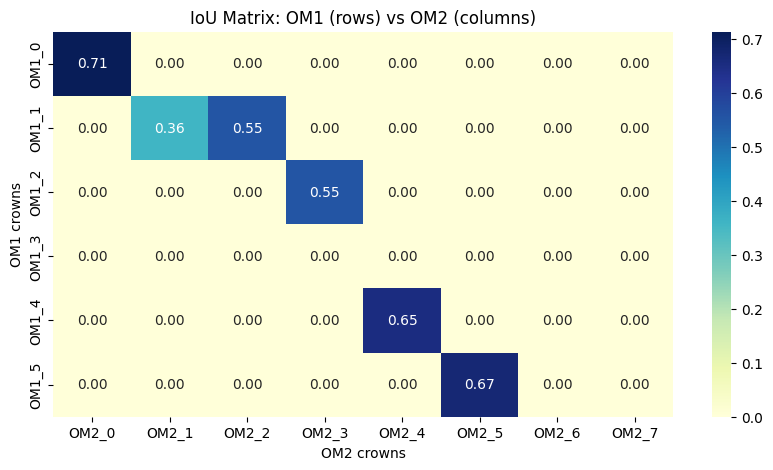

In [12]:
# --- Compute IoU Matrix and Visualize ---
def compute_iou(poly1, poly2):
    inter = poly1.intersection(poly2).area
    union = poly1.union(poly2).area
    return inter / union if union > 0 else 0

# Compute IoU matrix
iou_matrix = np.zeros((len(gdf1), len(gdf2)))
for i, row1 in gdf1.iterrows():
    for j, row2 in gdf2.iterrows():
        iou_matrix[i, j] = compute_iou(row1.geometry, row2.geometry)

# Show as DataFrame for clarity
iou_df = pd.DataFrame(iou_matrix, index=gdf1['id'], columns=gdf2['id'])
print('IoU Matrix (rounded):')
display(iou_df.round(2))

# Visualize as heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(iou_df, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('IoU Matrix: OM1 (rows) vs OM2 (columns)')
plt.xlabel('OM2 crowns')
plt.ylabel('OM1 crowns')
plt.show()

### Interpreting the IoU Matrix
- Each cell shows the overlap (IoU) between a crown in OM1 (row) and OM2 (column).
- High values (close to 1) indicate strong matches.
- We will use a threshold (e.g., 0.15) to decide if two crowns are considered a match.
- Multiple high values in a row or column indicate splits, merges, or ambiguous matches.

In [13]:
# --- Build Tracking Graph ---
# We connect OM1 crowns to OM2 crowns if IoU > threshold
IOU_THRESHOLD = 0.15
G = nx.DiGraph()

# Add nodes for both time points
gdf1['t'] = 1
gdf2['t'] = 2
for _, row in gdf1.iterrows():
    G.add_node(row['id'], t=1, geometry=row.geometry)
for _, row in gdf2.iterrows():
    G.add_node(row['id'], t=2, geometry=row.geometry)

# Add edges for matches
edges = []
for i, row1 in gdf1.iterrows():
    for j, row2 in gdf2.iterrows():
        iou = iou_matrix[i, j]
        if iou > IOU_THRESHOLD:
            G.add_edge(row1['id'], row2['id'], iou=iou)
            edges.append({'from': row1['id'], 'to': row2['id'], 'iou': iou})

edges_df = pd.DataFrame(edges)
print('Edges (matches) in the tracking graph:')
display(edges_df.sort_values('iou', ascending=False).reset_index(drop=True))

Edges (matches) in the tracking graph:


,from,to,iou
0,OM1_0,OM2_0,0.713844
1,OM1_5,OM2_5,0.671489
2,OM1_4,OM2_4,0.653444
3,OM1_2,OM2_3,0.554020
4,OM1_1,OM2_2,0.553264
5,OM1_1,OM2_1,0.357419


### Interpreting the Tracking Graph
- Each edge connects a crown in OM1 to a crown in OM2 with IoU above the threshold.
- Multiple edges from one OM1 crown to several OM2 crowns = **split**.
- Multiple edges to one OM2 crown from several OM1 crowns = **merge**.
- Crowns in OM1 with no outgoing edges = **disappear**.
- Crowns in OM2 with no incoming edges = **appear**.
- Multiple edges in both directions = **ambiguous**.

/var/folders/cx/8v11zwh97cxgdgt_ph13_56r0000gn/T/ipykernel_30598/3258393121.py:23: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/var/folders/cx/8v11zwh97cxgdgt_ph13_56r0000gn/T/ipykernel_30598/3258393121.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


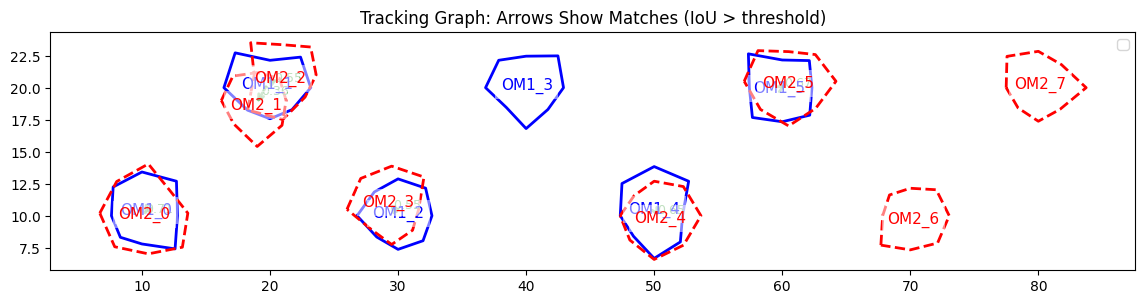

In [14]:
# --- Visualize the Tracking Graph and Highlight Cases ---
fig, ax = plt.subplots(figsize=(14, 8))
gdf1.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2, label='OM1')
gdf2.plot(ax=ax, facecolor='none', edgecolor='red', linestyle='--', linewidth=2, label='OM2')

# Draw arrows for edges
for u, v, data in G.edges(data=True):
    c1 = G.nodes[u]['geometry'].centroid
    c2 = G.nodes[v]['geometry'].centroid
    ax.annotate('', xy=(c2.x, c2.y), xytext=(c1.x, c1.y),
                arrowprops=dict(arrowstyle='->', color='green', lw=2, alpha=0.7))
    ax.text((c1.x+c2.x)/2, (c1.y+c2.y)/2, f"{data['iou']:.2f}", color='green', fontsize=9)

# Label nodes
for i, row in gdf1.iterrows():
    c = row.geometry.centroid
    ax.text(c.x, c.y, row['id'], color='blue', fontsize=11, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
for i, row in gdf2.iterrows():
    c = row.geometry.centroid
    ax.text(c.x, c.y, row['id'], color='red', fontsize=11, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

ax.set_title('Tracking Graph: Arrows Show Matches (IoU > threshold)')
ax.legend()
plt.show()

In [15]:
# --- Summarize All Cases in Tables ---
# 1-1: single outgoing and incoming edge
# Split: one OM1 to multiple OM2
# Merge: multiple OM1 to one OM2
# Disappear: OM1 with no outgoing
# Appear: OM2 with no incoming
# Ambiguous: multiple matches in both directions

# Outgoing and incoming edges
g1_out = {n: list(G.successors(n)) for n in gdf1['id']}
g2_in = {n: list(G.predecessors(n)) for n in gdf2['id']}

# 1-1 matches
one2one = [(n, outs[0]) for n, outs in g1_out.items() if len(outs)==1 and len(g2_in[outs[0]])==1]
# Splits
splits = [(n, outs) for n, outs in g1_out.items() if len(outs)>1]
# Merges
merges = [(n2, ins) for n2, ins in g2_in.items() if len(ins)>1]
# Disappears
disappears = [n for n, outs in g1_out.items() if len(outs)==0]
# Appears
appears = [n for n, ins in g2_in.items() if len(ins)==0]
# Ambiguous (multiple in and out)
ambiguous = [(n, outs) for n, outs in g1_out.items() if len(outs)>1 and any(len(g2_in[o])>1 for o in outs)]

print('1-to-1 matches:')
display(pd.DataFrame(one2one, columns=['OM1', 'OM2']))
print('Splits (one OM1 to many OM2):')
display(pd.DataFrame(splits, columns=['OM1', 'OM2 list']))
print('Merges (many OM1 to one OM2):')
display(pd.DataFrame(merges, columns=['OM2', 'OM1 list']))
print('Disappeared (OM1, no match in OM2):', disappears)
print('Appeared (OM2, no match in OM1):', appears)
print('Ambiguous cases:', ambiguous)

1-to-1 matches:


,OM1,OM2
0,OM1_0,OM2_0
1,OM1_2,OM2_3
2,OM1_4,OM2_4
3,OM1_5,OM2_5


Splits (one OM1 to many OM2):


,OM1,OM2 list
0,OM1_1,"[OM2_1, OM2_2]"


Merges (many OM1 to one OM2):


,OM2,OM1 list


Disappeared (OM1, no match in OM2): ['OM1_3']
Appeared (OM2, no match in OM1): ['OM2_6', 'OM2_7']
Ambiguous cases: []


## 11. Next Steps
- Replace simulated crowns with real crown GeoJSONs from your pipeline.
- Add more attributes to nodes/edges (confidence, area, etc).
- Try more advanced matching (Hungarian algorithm, etc) for optimal assignment.
- Visualize temporal changes, track new/missing trees, etc.

/var/folders/cx/8v11zwh97cxgdgt_ph13_56r0000gn/T/ipykernel_35146/1548944481.py:100: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/var/folders/cx/8v11zwh97cxgdgt_ph13_56r0000gn/T/ipykernel_35146/1548944481.py:100: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


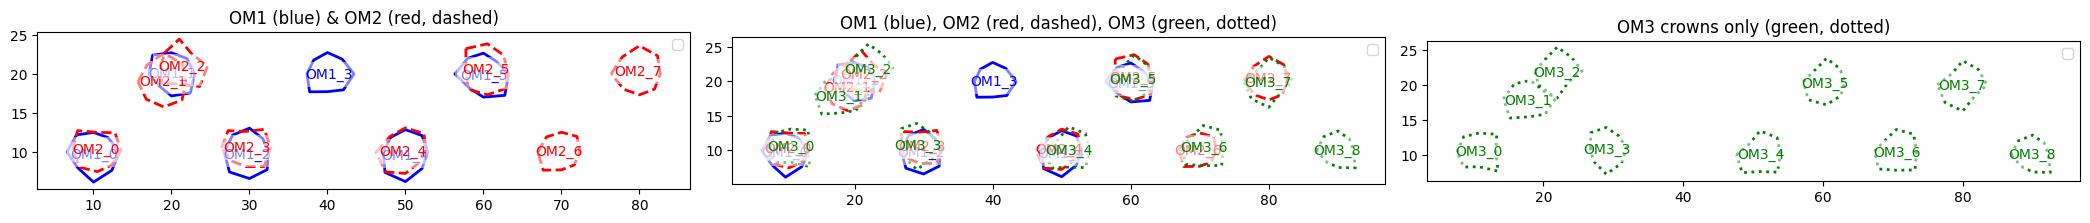

In [8]:
# --- Construct Three Sets of Polygons (OM1, OM2, OM3) Covering All Cases ---
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
import networkx as nx
import pandas as pd
import random

random.seed(123)
np.random.seed(123)

def random_polygon(center, size=1.0, n_points=8):
    angle = np.linspace(0, 2*np.pi, n_points, endpoint=False)
    radius = size * (0.7 + 0.6 * np.random.rand(n_points))
    x = center[0] + radius * np.cos(angle)
    y = center[1] + radius * np.sin(angle)
    return Polygon(zip(x, y))

# OM1: 6 trees (covering all cases)
om1_centers = [
    (10, 10),   # 1-to-1 match
    (20, 20),   # split in OM2
    (30, 10),   # merge in OM2
    (40, 20),   # disappears
    (50, 10),   # ambiguous
    (60, 20)    # 1-to-1 match (for OM3 appear/disappear)
]
om1_crowns = [random_polygon(c, size=3) for c in om1_centers]

# OM2: 8 trees
om2_centers = [
    (10.5, 10.2),   # 1-to-1 match (OM1_0)
    (19, 19),       # split (OM1_1)
    (21, 21),       # split (OM1_1)
    (29.5, 10.5),   # merge (OM1_2, OM1_4)
    (50, 10),       # ambiguous (OM1_4)
    (60.5, 20.5),   # 1-to-1 match (OM1_5)
    (70, 10),       # appear (new)
    (80, 20)        # appear (new)
]
om2_crowns = [random_polygon(c, size=3) for c in om2_centers]

# OM3: 9 trees
om3_centers = [
    (10.8, 10.4),   # 1-to-1 match (OM1_0→OM2_0)
    (18, 18),       # split chain (OM1_1→OM2_1,OM2_2)
    (22, 22),       # split chain (OM1_1→OM2_1,OM2_2)
    (29, 11),       # merge chain (OM1_2,OM1_4→OM2_3)
    (51, 10),       # ambiguous chain (OM1_4→OM2_3,OM2_4)
    (60.5, 20.5),   # 1-to-1 match (OM1_5)
    (70.5, 10.5),   # appear (new)
    (80, 20),       # appear (new)
    (90, 10)        # appear (new, OM3 only)
]
om3_crowns = [random_polygon(c, size=3) for c in om3_centers]

# Build GeoDataFrames
om1_ids = [f'OM1_{i}' for i in range(len(om1_crowns))]
om2_ids = [f'OM2_{i}' for i in range(len(om2_crowns))]
om3_ids = [f'OM3_{i}' for i in range(len(om3_crowns))]
gdf_om1 = gpd.GeoDataFrame({'id': om1_ids}, geometry=om1_crowns)
gdf_om2 = gpd.GeoDataFrame({'id': om2_ids}, geometry=om2_crowns)
gdf_om3 = gpd.GeoDataFrame({'id': om3_ids}, geometry=om3_crowns)

# --- Overlay Visualizations ---
fig, axes = plt.subplots(1, 3, figsize=(21, 7))
gdf_om1.plot(ax=axes[0], facecolor='none', edgecolor='blue', linewidth=2, label='OM1')
gdf_om2.plot(ax=axes[0], facecolor='none', edgecolor='red', linestyle='--', linewidth=2, label='OM2')
axes[0].set_title('OM1 (blue) & OM2 (red, dashed)')
for i, row in gdf_om1.iterrows():
    c = row.geometry.centroid
    axes[0].text(c.x, c.y, row['id'], color='blue', fontsize=10, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
for i, row in gdf_om2.iterrows():
    c = row.geometry.centroid
    axes[0].text(c.x, c.y, row['id'], color='red', fontsize=10, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

gdf_om1.plot(ax=axes[1], facecolor='none', edgecolor='blue', linewidth=2, label='OM1')
gdf_om2.plot(ax=axes[1], facecolor='none', edgecolor='red', linestyle='--', linewidth=2, label='OM2')
gdf_om3.plot(ax=axes[1], facecolor='none', edgecolor='green', linestyle=':', linewidth=2, label='OM3')
axes[1].set_title('OM1 (blue), OM2 (red, dashed), OM3 (green, dotted)')
for i, row in gdf_om1.iterrows():
    c = row.geometry.centroid
    axes[1].text(c.x, c.y, row['id'], color='blue', fontsize=10, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
for i, row in gdf_om2.iterrows():
    c = row.geometry.centroid
    axes[1].text(c.x, c.y, row['id'], color='red', fontsize=10, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
for i, row in gdf_om3.iterrows():
    c = row.geometry.centroid
    axes[1].text(c.x, c.y, row['id'], color='green', fontsize=10, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

gdf_om3.plot(ax=axes[2], facecolor='none', edgecolor='green', linestyle=':', linewidth=2, label='OM3')
axes[2].set_title('OM3 crowns only (green, dotted)')
for i, row in gdf_om3.iterrows():
    c = row.geometry.centroid
    axes[2].text(c.x, c.y, row['id'], color='green', fontsize=10, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

for ax in axes:
    ax.set_aspect('equal')
    ax.legend()
plt.tight_layout()
plt.show()


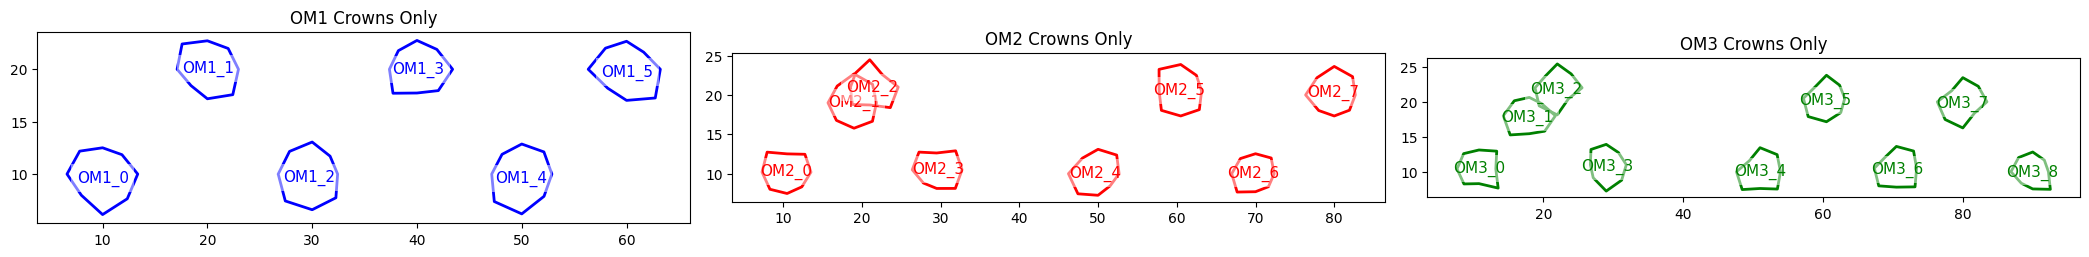

In [9]:
# --- Print OM1, OM2, OM3 Crowns Separately ---
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# OM1 only
ax = axes[0]
gdf_om1.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2)
for i, row in gdf_om1.iterrows():
    c = row.geometry.centroid
    ax.text(c.x, c.y, row['id'], color='blue', fontsize=11, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
ax.set_title('OM1 Crowns Only')
ax.set_aspect('equal')

# OM2 only
ax = axes[1]
gdf_om2.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
for i, row in gdf_om2.iterrows():
    c = row.geometry.centroid
    ax.text(c.x, c.y, row['id'], color='red', fontsize=11, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
ax.set_title('OM2 Crowns Only')
ax.set_aspect('equal')

# OM3 only
ax = axes[2]
gdf_om3.plot(ax=ax, facecolor='none', edgecolor='green', linewidth=2)
for i, row in gdf_om3.iterrows():
    c = row.geometry.centroid
    ax.text(c.x, c.y, row['id'], color='green', fontsize=11, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
ax.set_title('OM3 Crowns Only')
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

### Explanation of Simulated Cases (OM1, OM2, OM3)
- **OM1_0 → OM2_0 → OM3_0**: 1-to-1 match (persistent tree, slight shift each time)
- **OM1_1 → OM2_1, OM2_2 → OM3_1, OM3_2**: Split chain (one tree splits into two, then both persist)
- **OM1_2, OM1_4 → OM2_3 → OM3_3**: Merge chain (two trees merge, then persist as one)
- **OM1_3**: Disappears after OM1 (no match in OM2 or OM3)
- **OM2_5, OM2_6 → OM3_5, OM3_6, OM3_7**: Appear (new trees in OM2, some persist and new ones appear in OM3)
- **OM1_4 → OM2_3, OM2_4 → OM3_4**: Ambiguous/overlapping (OM1_4 could match OM2_3 or OM2_4, OM2_4 could match OM3_4)

The overlays above show all crowns, labeled by their IDs, for each orthomosaic and their combinations.

/var/folders/cx/8v11zwh97cxgdgt_ph13_56r0000gn/T/ipykernel_35146/2189528025.py:36: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/var/folders/cx/8v11zwh97cxgdgt_ph13_56r0000gn/T/ipykernel_35146/2189528025.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


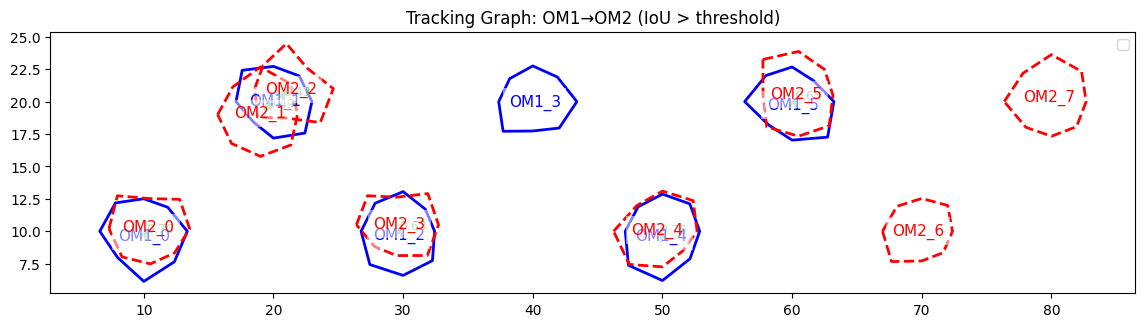

/var/folders/cx/8v11zwh97cxgdgt_ph13_56r0000gn/T/ipykernel_35146/2189528025.py:36: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/var/folders/cx/8v11zwh97cxgdgt_ph13_56r0000gn/T/ipykernel_35146/2189528025.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


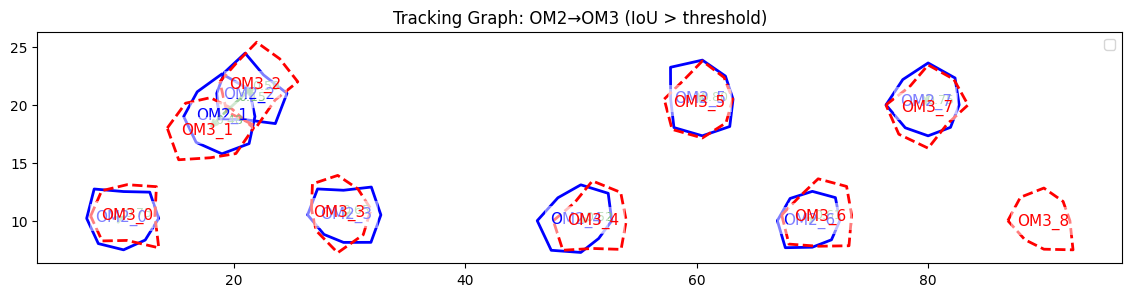

--- OM1→OM2 Cases ---
1-to-1 matches:


,From,To
0,OM1_0,OM2_0
1,OM1_2,OM2_3
2,OM1_4,OM2_4
3,OM1_5,OM2_5


Splits (one to many):


,From,To list
0,OM1_1,"[OM2_1, OM2_2]"


Merges (many to one):


,To,From list


Disappeared (no match in next OM): ['OM1_3']
Appeared (no match in prev OM): ['OM2_6', 'OM2_7']
Ambiguous cases: []
--- OM2→OM3 Cases ---
1-to-1 matches:


,From,To
0,OM2_0,OM3_0
1,OM2_3,OM3_3
2,OM2_4,OM3_4
3,OM2_5,OM3_5
4,OM2_6,OM3_6
5,OM2_7,OM3_7


Splits (one to many):


,From,To list
0,OM2_1,"[OM3_1, OM3_2]"


Merges (many to one):


,To,From list
0,OM3_2,"[OM2_1, OM2_2]"


Disappeared (no match in next OM): []
Appeared (no match in prev OM): ['OM3_8']
Ambiguous cases: [('OM2_1', ['OM3_1', 'OM3_2'])]


In [12]:
# --- Visualize OM1→OM2 and OM2→OM3 Tracking Graphs and Summarize Cases ---
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

def plot_tracking_graph(gdf_from, gdf_to, iou_matrix, threshold, title_from, title_to, title_graph):
    G = nx.DiGraph()
    # Add nodes
    for _, row in gdf_from.iterrows():
        G.add_node(row['id'], t=1, geometry=row.geometry)
    for _, row in gdf_to.iterrows():
        G.add_node(row['id'], t=2, geometry=row.geometry)
    # Add edges
    for i, row1 in gdf_from.iterrows():
        for j, row2 in gdf_to.iterrows():
            iou = iou_matrix[i, j]
            if iou > threshold:
                G.add_edge(row1['id'], row2['id'], iou=iou)
    # Plot
    fig, ax = plt.subplots(figsize=(14, 8))
    gdf_from.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2, label=title_from)
    gdf_to.plot(ax=ax, facecolor='none', edgecolor='red', linestyle='--', linewidth=2, label=title_to)
    for u, v, data in G.edges(data=True):
        c1 = G.nodes[u]['geometry'].centroid
        c2 = G.nodes[v]['geometry'].centroid
        ax.annotate('', xy=(c2.x, c2.y), xytext=(c1.x, c1.y),
                    arrowprops=dict(arrowstyle='->', color='green', lw=2, alpha=0.7))
        ax.text((c1.x+c2.x)/2, (c1.y+c2.y)/2, f"{data['iou']:.2f}", color='green', fontsize=9)
    for i, row in gdf_from.iterrows():
        c = row.geometry.centroid
        ax.text(c.x, c.y, row['id'], color='blue', fontsize=11, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    for i, row in gdf_to.iterrows():
        c = row.geometry.centroid
        ax.text(c.x, c.y, row['id'], color='red', fontsize=11, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    ax.set_title(title_graph)
    ax.legend()
    plt.show()
    return G

# OM1→OM2
graph_12 = plot_tracking_graph(gdf_om1, gdf_om2, iou_12, IOU_THRESHOLD, 'OM1', 'OM2', 'Tracking Graph: OM1→OM2 (IoU > threshold)')
# OM2→OM3
graph_23 = plot_tracking_graph(gdf_om2, gdf_om3, iou_23, IOU_THRESHOLD, 'OM2', 'OM3', 'Tracking Graph: OM2→OM3 (IoU > threshold)')

# --- Summarize All Cases for OM1→OM2 ---
def summarize_graph_cases(G, gdf_from, gdf_to):
    g1_out = {n: list(G.successors(n)) for n in gdf_from['id']}
    g2_in = {n: list(G.predecessors(n)) for n in gdf_to['id']}
    one2one = [(n, outs[0]) for n, outs in g1_out.items() if len(outs)==1 and len(g2_in[outs[0]])==1]
    splits = [(n, outs) for n, outs in g1_out.items() if len(outs)>1]
    merges = [(n2, ins) for n2, ins in g2_in.items() if len(ins)>1]
    disappears = [n for n, outs in g1_out.items() if len(outs)==0]
    appears = [n for n, ins in g2_in.items() if len(ins)==0]
    ambiguous = [(n, outs) for n, outs in g1_out.items() if len(outs)>1 and any(len(g2_in[o])>1 for o in outs)]
    print('1-to-1 matches:')
    display(pd.DataFrame(one2one, columns=['From', 'To']))
    print('Splits (one to many):')
    display(pd.DataFrame(splits, columns=['From', 'To list']))
    print('Merges (many to one):')
    display(pd.DataFrame(merges, columns=['To', 'From list']))
    print('Disappeared (no match in next OM):', disappears)
    print('Appeared (no match in prev OM):', appears)
    print('Ambiguous cases:', ambiguous)

print('--- OM1→OM2 Cases ---')
summarize_graph_cases(graph_12, gdf_om1, gdf_om2)
print('--- OM2→OM3 Cases ---')
summarize_graph_cases(graph_23, gdf_om2, gdf_om3)


In [10]:
# --- Compute IoU Matrices and Build Full Tracking Graph (OM1→OM2→OM3) ---
def compute_iou(poly1, poly2):
    inter = poly1.intersection(poly2).area
    union = poly1.union(poly2).area
    return inter / union if union > 0 else 0

# Compute IoU matrices
iou_12 = np.zeros((len(gdf_om1), len(gdf_om2)))
for i, row1 in gdf_om1.iterrows():
    for j, row2 in gdf_om2.iterrows():
        iou_12[i, j] = compute_iou(row1.geometry, row2.geometry)

iou_23 = np.zeros((len(gdf_om2), len(gdf_om3)))
for i, row1 in gdf_om2.iterrows():
    for j, row2 in gdf_om3.iterrows():
        iou_23[i, j] = compute_iou(row1.geometry, row2.geometry)

# Build full directed graph: OM1→OM2→OM3
IOU_THRESHOLD = 0.15
G_full = nx.DiGraph()

# Add all nodes
for _, row in gdf_om1.iterrows():
    G_full.add_node(row['id'], t=1, geometry=row.geometry)
for _, row in gdf_om2.iterrows():
    G_full.add_node(row['id'], t=2, geometry=row.geometry)
for _, row in gdf_om3.iterrows():
    G_full.add_node(row['id'], t=3, geometry=row.geometry)

# Add OM1→OM2 edges
for i, row1 in gdf_om1.iterrows():
    for j, row2 in gdf_om2.iterrows():
        iou = iou_12[i, j]
        if iou > IOU_THRESHOLD:
            G_full.add_edge(row1['id'], row2['id'], iou=iou)

# Add OM2→OM3 edges
for i, row1 in gdf_om2.iterrows():
    for j, row2 in gdf_om3.iterrows():
        iou = iou_23[i, j]
        if iou > IOU_THRESHOLD:
            G_full.add_edge(row1['id'], row2['id'], iou=iou)

# For demonstration, show IoU matrices as DataFrames
iou12_df = pd.DataFrame(iou_12, index=gdf_om1['id'], columns=gdf_om2['id'])
iou23_df = pd.DataFrame(iou_23, index=gdf_om2['id'], columns=gdf_om3['id'])
print('IoU Matrix OM1→OM2 (rounded):')
display(iou12_df.round(2))
print('IoU Matrix OM2→OM3 (rounded):')
display(iou23_df.round(2))

IoU Matrix OM1→OM2 (rounded):


id,OM2_0,OM2_1,OM2_2,OM2_3,OM2_4,OM2_5,OM2_6,OM2_7
id,,,,,,,,
OM1_0,0.7,0.00,0.00,0.00,0.00,0.00,0.0,0.0
OM1_1,0.0,0.49,0.43,0.00,0.00,0.00,0.0,0.0
OM1_2,0.0,0.00,0.00,0.63,0.00,0.00,0.0,0.0
OM1_3,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0
OM1_4,0.0,0.00,0.00,0.00,0.75,0.00,0.0,0.0
OM1_5,0.0,0.00,0.00,0.00,0.00,0.65,0.0,0.0


IoU Matrix OM2→OM3 (rounded):


id,OM3_0,OM3_1,OM3_2,OM3_3,OM3_4,OM3_5,OM3_6,OM3_7,OM3_8
id,,,,,,,,,
OM2_0,0.73,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0
OM2_1,0.00,0.48,0.15,0.00,0.00,0.0,0.00,0.00,0.0
OM2_2,0.00,0.04,0.59,0.00,0.00,0.0,0.00,0.00,0.0
OM2_3,0.00,0.00,0.00,0.65,0.00,0.0,0.00,0.00,0.0
OM2_4,0.00,0.00,0.00,0.00,0.52,0.0,0.00,0.00,0.0
OM2_5,0.00,0.00,0.00,0.00,0.00,0.8,0.00,0.00,0.0
OM2_6,0.00,0.00,0.00,0.00,0.00,0.0,0.61,0.00,0.0
OM2_7,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.75,0.0


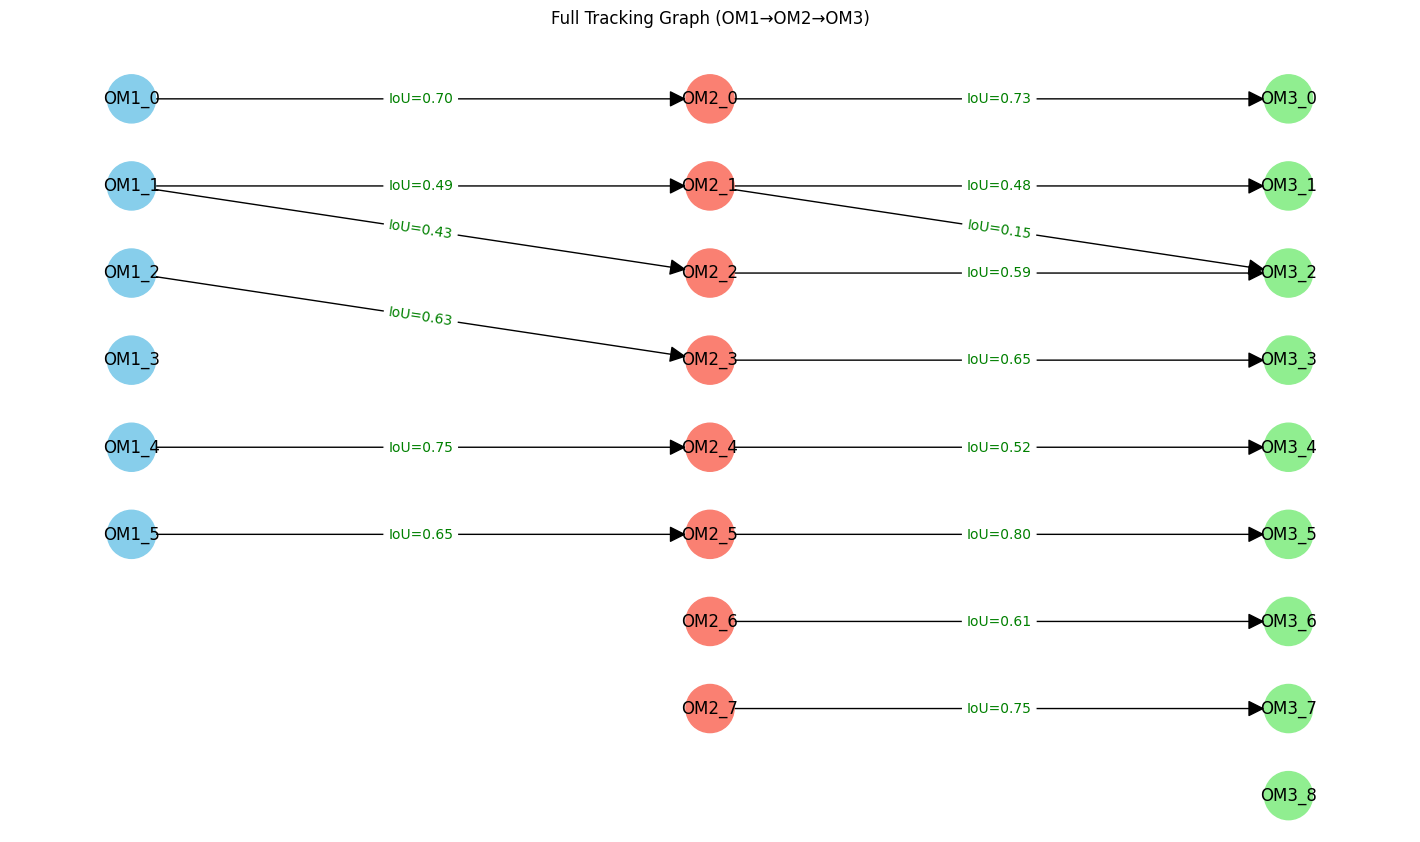

In [11]:
# --- Visualize Full OM1→OM2→OM3 Tracking Graph with IoU Labels ---
import matplotlib.pyplot as plt

def plot_full_temporal_graph(G, gdf_om1, gdf_om2, gdf_om3, title='Full Tracking Graph (OM1→OM2→OM3)'):
    pos = {}
    # Layered layout: OM1 (x=0), OM2 (x=2), OM3 (x=4)
    for i, row in gdf_om1.iterrows():
        pos[row['id']] = (0, -i)
    for i, row in gdf_om2.iterrows():
        pos[row['id']] = (2, -i)
    for i, row in gdf_om3.iterrows():
        pos[row['id']] = (4, -i)
    
    node_colors = []
    for n in G.nodes:
        t = G.nodes[n]['t']
        if t == 1: node_colors.append('skyblue')
        elif t == 2: node_colors.append('salmon')
        else: node_colors.append('lightgreen')
    
    plt.figure(figsize=(14, 8))
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1200, arrowsize=25)
    # Draw IoU edge labels
    edge_labels = {(u,v): f"IoU={G.edges[u,v]['iou']:.2f}" for u,v in G.edges if 'iou' in G.edges[u,v]}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='green')
    plt.title(title)
    plt.axis('off')
    plt.show()

plot_full_temporal_graph(G_full, gdf_om1, gdf_om2, gdf_om3)

### Writeup: What is Represented in the OM1→OM2→OM3 Tracking Graph
- **1-to-1 match**: A single path from OM1_0 → OM2_0 → OM3_0 shows a persistent tree tracked across all time points.
- **Split chain**: OM1_1 connects to both OM2_1 and OM2_2, which then connect to OM3_1 and OM3_2, representing a tree that splits and both descendants persist.
- **Merge chain**: OM1_2 and OM1_4 both connect to OM2_3, which then connects to OM3_3, representing two trees merging and persisting as one.
- **Disappear**: OM1_3 has no outgoing edges, indicating a tree that disappears after OM1.
- **Appear**: OM2_5, OM2_6 (and OM3_5, OM3_6, OM3_7) have no incoming edges from the previous OM, representing new trees appearing at later time points.
- **Ambiguous/overlapping**: OM1_4 connects to both OM2_3 and OM2_4, and OM2_4 connects to OM3_4, showing ambiguous or overlapping matches.
- **Temporal chains**: The graph structure encodes the full history of each tree, including splits, merges, appearances, disappearances, and ambiguous events, by following paths and branches through the layers.

**Each node is a crown at a specific time point. Each edge represents a likely match (IoU > threshold), with the IoU value as an edge attribute.**

# Comprehensive Demonstration: Tracking Across Three Orthomosaics
This section demonstrates all major cases of tree crown matching across three orthomosaics (OM1, OM2, OM3):
- 1-to-1 match
- Split (1-to-many)
- Merge (many-to-1)
- Appear/disappear
- Ambiguous/overlapping
- Temporal chains (split then merge, merge then split, etc.)

We will:
1. Construct three sets of polygons (OM1, OM2, OM3) to cover all cases.
2. Display overlays of OM1 & OM2, and all three sets together.
3. Show the full graph for OM1→OM2 and OM1→OM2→OM3, with IoU labels on edges.
4. Provide detailed writeups for each case and what is represented in the graph.

# Slide 1: Forward-Only Temporal Tracking Graph

**Key Points:**

1. **Causality Preserved:** Only forward edges (e.g., OM1→OM2→OM3) are allowed, reflecting the natural temporal order.
2. **Simplicity:** The graph is acyclic and easy to interpret; each path represents a possible temporal track.
3. **Lower Ambiguity:** Fewer possible tracks, so less risk of spurious or ambiguous matches.
4. **Limitations:** Missed detections or ambiguous matches cannot be recovered by looking backward in time.

---

*Visualization: Forward-only tracking graph (no cycles)*

In [ ]:
# Visualization: Forward-only tracking graph (no cycles)
import networkx as nx
import matplotlib.pyplot as plt

# Example: OM1→OM2→OM3, no backward edges
G_forward = nx.DiGraph()
G_forward.add_edges_from([
    ("OM1_1", "OM2_1"), ("OM1_2", "OM2_2"), ("OM1_3", "OM2_3"),
    ("OM2_1", "OM3_1"), ("OM2_2", "OM3_2"), ("OM2_3", "OM3_3")
])

pos = {"OM1_1": (0,2), "OM1_2": (0,1), "OM1_3": (0,0),
       "OM2_1": (1,2), "OM2_2": (1,1), "OM2_3": (1,0),
       "OM3_1": (2,2), "OM3_2": (2,1), "OM3_3": (2,0)}

plt.figure(figsize=(7,3))
nx.draw(G_forward, pos, with_labels=True, node_color='lightblue', arrowsize=20, node_size=1200)
plt.title("Forward-Only Tracking Graph (No Cycles)")
plt.axis('off')
plt.show()

# Slide 2: Bidirectional (Back-Matching) Temporal Tracking Graph

**Key Points:**

1. **Cycles Possible:** Allowing edges in both directions (e.g., OM2→OM1, OM3→OM2) introduces cycles in the graph.
2. **Increased Ambiguity:** Many possible tracks and cycles can make interpretation and track extraction more complex.
3. **Potential for Robustness:** Can help recover missed detections or ambiguous matches by leveraging information from all timepoints.
4. **Causality and Complexity:** Cycles may violate temporal causality and increase computational and interpretational complexity.

---

*Visualization: Bidirectional tracking graph (with cycles)*

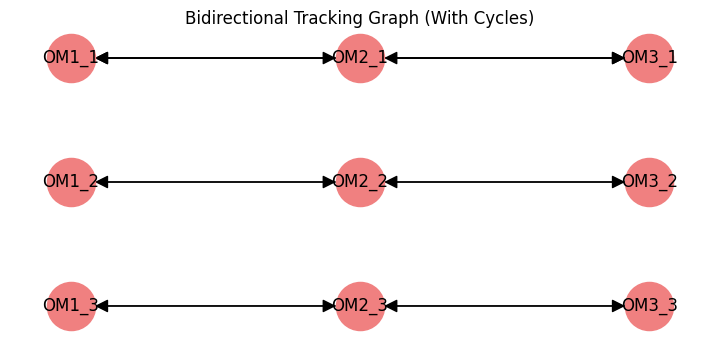

In [1]:
# Visualization: Bidirectional (back-matching) tracking graph (with cycles)
import networkx as nx
import matplotlib.pyplot as plt

# Example: OM1↔OM2↔OM3, all possible edges
G_bidir = nx.DiGraph()
G_bidir.add_edges_from([
    ("OM1_1", "OM2_1"), ("OM1_2", "OM2_2"), ("OM1_3", "OM2_3"),
    ("OM2_1", "OM1_1"), ("OM2_2", "OM1_2"), ("OM2_3", "OM1_3"),
    ("OM2_1", "OM3_1"), ("OM2_2", "OM3_2"), ("OM2_3", "OM3_3"),
    ("OM3_1", "OM2_1"), ("OM3_2", "OM2_2"), ("OM3_3", "OM2_3"),
    ("OM1_1", "OM3_1"), ("OM3_1", "OM1_1") # direct OM1↔OM3 for illustration
])

pos = {"OM1_1": (0,2), "OM1_2": (0,1), "OM1_3": (0,0),
       "OM2_1": (1,2), "OM2_2": (1,1), "OM2_3": (1,0),
       "OM3_1": (2,2), "OM3_2": (2,1), "OM3_3": (2,0)}

plt.figure(figsize=(7,3))
nx.draw(G_bidir, pos, with_labels=True, node_color='lightcoral', arrowsize=20, node_size=1200)
plt.title("Bidirectional Tracking Graph (With Cycles)")
plt.axis('off')
plt.show()

# Real Data: Crown Tracking Graph with and without Transformations
This section demonstrates how to run the crown tracking graph algorithm on real orthomosaic crown data, both with and without alignment, merging, and augmentation transformations.

**Required input:**
- One `.gpkg` file per orthomosaic (e.g., `OM1.gpkg`, `OM2.gpkg`, ...).
- (Optional) Corresponding `.tif` files for visualization.

**Steps:**
1. Specify file paths for your crown polygons and (optionally) orthomosaic images.
2. Load the crown polygons.
3. (Optional) Apply alignment, merging, and augmentation transformations.
4. Build and visualize the tracking graph for both raw and transformed crowns.
5. Summarize the results.